# Restricted Access Sequence Processing (RASP) for ReCOGS

https://github.com/willy-b/learning-rasp/pull/4

In this notebook we are doing light evaluation of a program to parse a grammar which is written in the Restricted Access Sequence Processing (RASP) language, which can be theoretically compiled to Transformer neural network weights.

Note, it is simpler and more performant to just train the Transformer on examples (or use a dedicated parsing program like Lark)! This is an academic exercise, writing a neural network compatible program by hand in the Restricted Access Sequence Processing (compilable to Transformer) language (Weiss et al 2021, https://arxiv.org/abs/2106.06981 ) to work towards eventually proving a Transformer can perform a particular type of solution (we will be building a grammar based and compositional solution).

Goal: Given the "COGS: A Compositional Generalization Challenge Based on Semantic Interpretation" (Kim and Linzen 2020, https://aclanthology.org/2020.emnlp-main.731 ) English input sentence grammar,
we implement the vocab and grammar for COGS courtesy of IBMs CPG project (their utilities, not their CPG itself) at https://github.com/IBM/cpg/blob/c3626b4e03bfc681be2c2a5b23da0b48abe6f570/src/model/cogs_data.py#L523 ) in the Restricted Access Sequence Processing language, using the parse to produce an output logical form in the modified ReCOGS logical form format from Wu et al 2023 (ReCOGS: How Incidental Details of a Logical Form Overshadow an Evaluation of Semantic Interpretation - https://arxiv.org/abs/2303.13716 ).

We start to support most of the grammar but not yet in recursive way (no recursive complement phrases or complement phrases) and not yet supporting some prepositional phrases. Just practicing all the pieces still.

We see we can translate these related example sentences into logical forms:

"the girl was painted" -> "* girl ( 1 ) ; painted ( 3 ) AND theme ( 3 , 1 )"

"a boy painted" -> "boy ( 1 ) ; painted ( 2 ) AND agent ( 2 , 1 )"

"a boy painted the girl" -> "boy ( 1 ) ; * girl ( 4 ) ; painted ( 2 ) AND agent ( 2 , 1 ) AND theme ( 2 , 4 )"

"the girl was painted by a boy" -> "* girl ( 1 ) ; boy ( 6 ) ; painted ( 3 ) AND theme ( 3 , 1 ) AND agent ( 3 , 6 )"

While supporting additional forms in the grammar as well .

Parse trees of a couple of these sentences in this grammar produced by the Lark parser for reference (sentences chosen with different syntax but same semantics to emphasize difference between logical form and original sentence):

![cogs_input_sentences_parsed_by_lark_with_parse_trees](https://github.com/user-attachments/assets/5054c9b1-190c-4688-99ca-3882db1e89fa)

Then note that while the syntax (parse trees above) are very different, the semantics are the same after converting into logical form (further write as graph in dot to emphasize):

![same semantics](https://github.com/user-attachments/assets/f2303e9a-efc1-4dbe-a922-352ef09b65ba)

If, using Restricted Access Sequence Processing we can prove a Transformer can learn a compositional , grammar-based, systematic solution, that is a good starting point to why Transformers are not actually learning such solutions and how to bias them to learn the right type of solution, rather than brittle shortcuts (as COGS challenge suggests that Transformers learning this task from scratch learn non-compositional solutions that have generalization problems).


# Obtain Restricted Access Sequence Processing interpreter to run our program

In [1]:
!git clone https://github.com/tech-srl/RASP.git

Cloning into 'RASP'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 428 (delta 151), reused 145 (delta 121), pack-reused 216 (from 1)
Receiving objects: 100% (428/428), 319.15 KiB | 7.09 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [2]:
%cd RASP


/content/RASP


In [3]:
!apt install python3.10-venv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-pip-whl python3-setuptools-whl
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-venv
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,474 kB of archives.
After this operation, 2,885 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip-whl all 22.0.2+dfsg-1ubuntu0.4 [1,680 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-setuptools-whl all 59.6.0-1.2ubuntu0.22.04.2 [788 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3.10-venv amd64 3.10.12-1~22.04.6 [5,722 B]
Fetched 2,474 kB in 1s (2,767 kB/s)
Selecting previously unselected package python3-pip-whl.
(Reading database ... 123622 files and directories currently installed.)
Pr

In [4]:
!./setup.sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following NEW packages will be installed:
  rlwrap
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 98.2 kB of archives.
After this operation, 309 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 rlwrap amd64 0.43-1build3 [98.2 kB]
Fetched 98.2 kB in 0s (281 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package rlwra

create a version of `rasp.sh` we can run from python:

In [5]:
import os
with open("/content/RASP/rasp2.sh", "w") as f:
  f.write("""#!/bin/bash
source raspenv/bin/activate

if [[ $(rlwrap -v) == rlwrap* ]]; then
	# the better option. requires rlwrap
	rlwrap python3 -m RASP_support
else
	python3 -m RASP_support
fi

deactivate
  """)
os.chmod("/content/RASP/rasp2.sh", 750)

# Load my code for parsing the COGS input sentences written in Restricted Access Sequence Processing (Transformers compatible programming language, not for prompts but compiles to weights instead of training a Transformer)

(academic language for proving what Transformers can do; in this language I can ensure for example all common nouns are represented identically, and that nouns in different roles are treated identically, so can prove Transformers can do a solution with certain properties)

In [6]:
!git clone https://github.com/willy-b/learning-rasp.git

Cloning into 'learning-rasp'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 99 (delta 53), reused 67 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 100.06 KiB | 4.17 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [7]:
%cd learning-rasp
!git checkout recogs-like-grammar-multiple-templates-supported-but-switch-to-word-level-tokens
%cd ..

/content/RASP/learning-rasp
Branch 'recogs-like-grammar-multiple-templates-supported-but-switch-to-word-level-tokens' set up to track remote branch 'recogs-like-grammar-multiple-templates-supported-but-switch-to-word-level-tokens' from 'origin'.
Switched to a new branch 'recogs-like-grammar-multiple-templates-supported-but-switch-to-word-level-tokens'
/content/RASP


Setting up an interpreter with the base RASP program and then autoregressively passing it the current example plus its last prediction

In [8]:
import subprocess
import pty
main, secondary = pty.openpty()
proc = subprocess.Popen("/content/RASP/rasp2.sh", shell=True, stdin=subprocess.PIPE, stdout=secondary)
stdin_handle = proc.stdin
stdout_handle = os.fdopen(main)

with open("learning-rasp/word-level-pos-tokens-recogs-style-decoder-loop.rasp", "r") as f:
  rasp_setup_lines = f.readlines()
input_lines = [bytes(line, 'utf8') for line in rasp_setup_lines]

stdin_handle.writelines(input_lines)
stdin_handle.flush()


skipping the lines at the end of the file with builtin examples for speed but I skipped too much after latest change which added more code, that is why I had to restart after increasing the number of lines read.

In [9]:
# discard all output from running the setup part of the script
input_lines = ["autoregressive_output = output;\n"]
input_lines = [bytes(line, 'utf8') for line in input_lines]
stdin_handle.writelines(input_lines)
stdin_handle.flush()
outputline = stdout_handle.readline()
while outputline.find("Example: autoregressive_output") < 0:
  outputline = stdout_handle.readline()

In [10]:
def process_example(example, suppress_output=True, debug_mode=False):
  current_example = example.lower().split(" ")
  nextcharacter = " "
  while nextcharacter != "":
    next_input = f"set example {current_example}\nautoregressive_output;\n".replace("'", '"')
    input_lines = [next_input]
    input_lines = [bytes(line, 'utf8') for line in input_lines]
    stdin_handle.writelines(input_lines)
    stdin_handle.flush()
    outputline = stdout_handle.readline()
    lines_skipped = 0
    while outputline.find("Example: autoregressive_output") < 0:
      if debug_mode:
        print(f"skipping: {outputline}")
      outputline = stdout_handle.readline()
      lines_skipped += 1
      if lines_skipped > 20:
        return " ".join(current_example).split("|")[1]
    if not suppress_output:
      print(outputline)
    nextcharacter = outputline.split("=")[1].split("m[")[1].split("]")[0]
    current_example.append(nextcharacter)
  translation = " ".join(current_example).split("|")
  if not suppress_output:
    print(f"{translation[0]}\n{translation[1]}")
  return translation[1]

# Process some examples


We can use entries from https://raw.githubusercontent.com/frankaging/ReCOGS/refs/heads/main/recogs_positional_index/train.tsv but MUST exclude anything without "in_distribution" at the end as we are using the COGS input grammar (NOT ReCOGS modified, like preposing and sprinkles, which are not supported yet.)

COMPLEMENT PHRASES AND RECURSION ALSO NOT SUPPORTED YET.

In [11]:
!wget https://raw.githubusercontent.com/frankaging/ReCOGS/refs/heads/main/recogs_positional_index/train.tsv
!head -n 10 train.tsv | grep 'in_distribution'

--2024-10-27 16:55:52--  https://raw.githubusercontent.com/frankaging/ReCOGS/refs/heads/main/recogs_positional_index/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5167774 (4.9M) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]   4.93M  --.-KB/s    in 0.08s   

2024-10-27 16:55:52 (62.8 MB/s) - ‘train.tsv’ saved [5167774/5167774]

A rose was helped by a dog .	rose ( 1 ) ; dog ( 6 ) ; help ( 3 ) AND theme ( 3 , 1 ) AND agent ( 3 , 6 )	in_distribution
The sailor dusted a boy .	* sailor ( 1 ) ; boy ( 4 ) ; dust ( 2 ) AND agent ( 2 , 1 ) AND theme ( 2 , 4 )	in_distribution
Emma rolled a teacher .	Emma ( 0 ) ; teacher ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 )	in_distribution
Evelyn rolled the girl .	E

In [12]:
process_example("A rose was helped by a dog", False)

 	 Example: autoregressive_output(['a', 'rose', 'was', 'helped', 'by', 'a', 'dog']) = [|]*7 (strings)

 	 Example: autoregressive_output(['a', 'rose', 'was', 'helped', 'by', 'a', 'dog', '|']) = [rose]*8 (strings)

 	 Example: autoregressive_output(['a', 'rose', 'was', 'helped', 'by', 'a', 'dog', '|', 'rose']) = [(]*9 (strings)

 	 Example: autoregressive_output(['a', 'rose', 'was', 'helped', 'by', 'a', 'dog', '|', 'rose', '(']) = [1]*10 (ints)

 	 Example: autoregressive_output(['a', 'rose', 'was', 'helped', 'by', 'a', 'dog', '|', 'rose', '(', '1']) = [)]*11 (strings)

 	 Example: autoregressive_output(['a', 'rose', 'was', 'helped', 'by', 'a', 'dog', '|', 'rose', '(', '1', ')']) = [;]*12 (strings)

 	 Example: autoregressive_output(['a', 'rose', 'was', 'helped', 'by', 'a', 'dog', '|', 'rose', '(', '1', ')', ';']) = [dog]*13 (strings)

 	 Example: autoregressive_output(['a', 'rose', 'was', 'helped', 'by', 'a', 'dog', '|', 'rose', '(', '1', ')', ';', 'dog']) = [(]*14 (strings)

 	 Exampl

' rose ( 1 ) ; dog ( 6 ) ; help ( 3 ) AND theme ( 3 , 1 ) AND agent ( 3 , 6 ) '

In [13]:
process_example("The sailor dusted a boy", False)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy']) = [|]*5 (strings)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy', '|']) = [*]*6 (strings)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy', '|', '*']) = [sailor]*7 (strings)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy', '|', '*', 'sailor']) = [(]*8 (strings)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy', '|', '*', 'sailor', '(']) = [1]*9 (ints)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy', '|', '*', 'sailor', '(', '1']) = [)]*10 (strings)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy', '|', '*', 'sailor', '(', '1', ')']) = [;]*11 (strings)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy', '|', '*', 'sailor', '(', '1', ')', ';']) = [boy]*12 (strings)

 	 Example: autoregressive_output(['the', 'sailor', 'dusted', 'a', 'boy', '|

' * sailor ( 1 ) ; boy ( 4 ) ; dust ( 2 ) AND agent ( 2 , 1 ) AND theme ( 2 , 4 ) '

In [14]:
process_example("Emma rolled a teacher", False)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher']) = [|]*4 (strings)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher', '|']) = [emma]*5 (strings)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher', '|', 'emma']) = [(]*6 (strings)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher', '|', 'emma', '(']) = [0]*7 (ints)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher', '|', 'emma', '(', '0']) = [)]*8 (strings)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher', '|', 'emma', '(', '0', ')']) = [;]*9 (strings)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher', '|', 'emma', '(', '0', ')', ';']) = [teacher]*10 (strings)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher', '|', 'emma', '(', '0', ')', ';', 'teacher']) = [(]*11 (strings)

 	 Example: autoregressive_output(['emma', 'rolled', 'a', 'teacher', '|', 'emma', '(', '0', ')', ';', 'teacher', '('

' emma ( 0 ) ; teacher ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 ) '

In [15]:
process_example("Evelyn rolled the girl", False)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl']) = [|]*4 (strings)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl', '|']) = [evelyn]*5 (strings)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl', '|', 'evelyn']) = [(]*6 (strings)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl', '|', 'evelyn', '(']) = [0]*7 (ints)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl', '|', 'evelyn', '(', '0']) = [)]*8 (strings)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl', '|', 'evelyn', '(', '0', ')']) = [;]*9 (strings)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl', '|', 'evelyn', '(', '0', ')', ';']) = [*]*10 (strings)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl', '|', 'evelyn', '(', '0', ')', ';', '*']) = [girl]*11 (strings)

 	 Example: autoregressive_output(['evelyn', 'rolled', 'the', 'girl', '|', 'evelyn', '(', '0', ')', ';'

' evelyn ( 0 ) ; * girl ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 ) '

In [16]:
process_example("The pen was offered to the girl by Emma", False)

 	 Example: autoregressive_output(['the', 'pen', 'was', 'offered', 'to', 'the', 'girl', 'by', 'emma']) = [|]*9 (strings)

 	 Example: autoregressive_output(['the', 'pen', 'was', 'offered', 'to', 'the', 'girl', 'by', 'emma', '|']) = [*]*10 (strings)

 	 Example: autoregressive_output(['the', 'pen', 'was', 'offered', 'to', 'the', 'girl', 'by', 'emma', '|', '*']) = [pen]*11 (strings)

 	 Example: autoregressive_output(['the', 'pen', 'was', 'offered', 'to', 'the', 'girl', 'by', 'emma', '|', '*', 'pen']) = [(]*12 (strings)

 	 Example: autoregressive_output(['the', 'pen', 'was', 'offered', 'to', 'the', 'girl', 'by', 'emma', '|', '*', 'pen', '(']) = [1]*13 (ints)

 	 Example: autoregressive_output(['the', 'pen', 'was', 'offered', 'to', 'the', 'girl', 'by', 'emma', '|', '*', 'pen', '(', '1']) = [)]*14 (strings)

 	 Example: autoregressive_output(['the', 'pen', 'was', 'offered', 'to', 'the', 'girl', 'by', 'emma', '|', '*', 'pen', '(', '1', ')']) = [;]*15 (strings)

 	 Example: autoregressive_o

' * pen ( 1 ) ; * girl ( 6 ) ; emma ( 8 ) ; offer ( 3 ) AND theme ( 3 , 1 ) AND recipient ( 3 , 6 ) AND agent ( 3 , 8 ) '

This one is just for fun as has multiple left-of-verb prepositional phrases modifying the agent noun.


In [17]:
process_example("The boy on the chair in the house ate the donut", False)

 	 Example: autoregressive_output(['the', 'boy', 'on', 'the', 'chair', 'in', 'the', 'house', 'ate', 'the', 'donut']) = [|]*11 (strings)

 	 Example: autoregressive_output(['the', 'boy', 'on', 'the', 'chair', 'in', 'the', 'house', 'ate', 'the', 'donut', '|']) = [*]*12 (strings)

 	 Example: autoregressive_output(['the', 'boy', 'on', 'the', 'chair', 'in', 'the', 'house', 'ate', 'the', 'donut', '|', '*']) = [boy]*13 (strings)

 	 Example: autoregressive_output(['the', 'boy', 'on', 'the', 'chair', 'in', 'the', 'house', 'ate', 'the', 'donut', '|', '*', 'boy']) = [(]*14 (strings)

 	 Example: autoregressive_output(['the', 'boy', 'on', 'the', 'chair', 'in', 'the', 'house', 'ate', 'the', 'donut', '|', '*', 'boy', '(']) = [1]*15 (ints)

 	 Example: autoregressive_output(['the', 'boy', 'on', 'the', 'chair', 'in', 'the', 'house', 'ate', 'the', 'donut', '|', '*', 'boy', '(', '1']) = [)]*16 (strings)

 	 Example: autoregressive_output(['the', 'boy', 'on', 'the', 'chair', 'in', 'the', 'house', 'ate'

' * boy ( 1 ) ; * chair ( 4 ) ; * house ( 7 ) ; * donut ( 10 ) ; eat ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 ) AND nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) '

Explanation of why that example is interesting is in the image below:


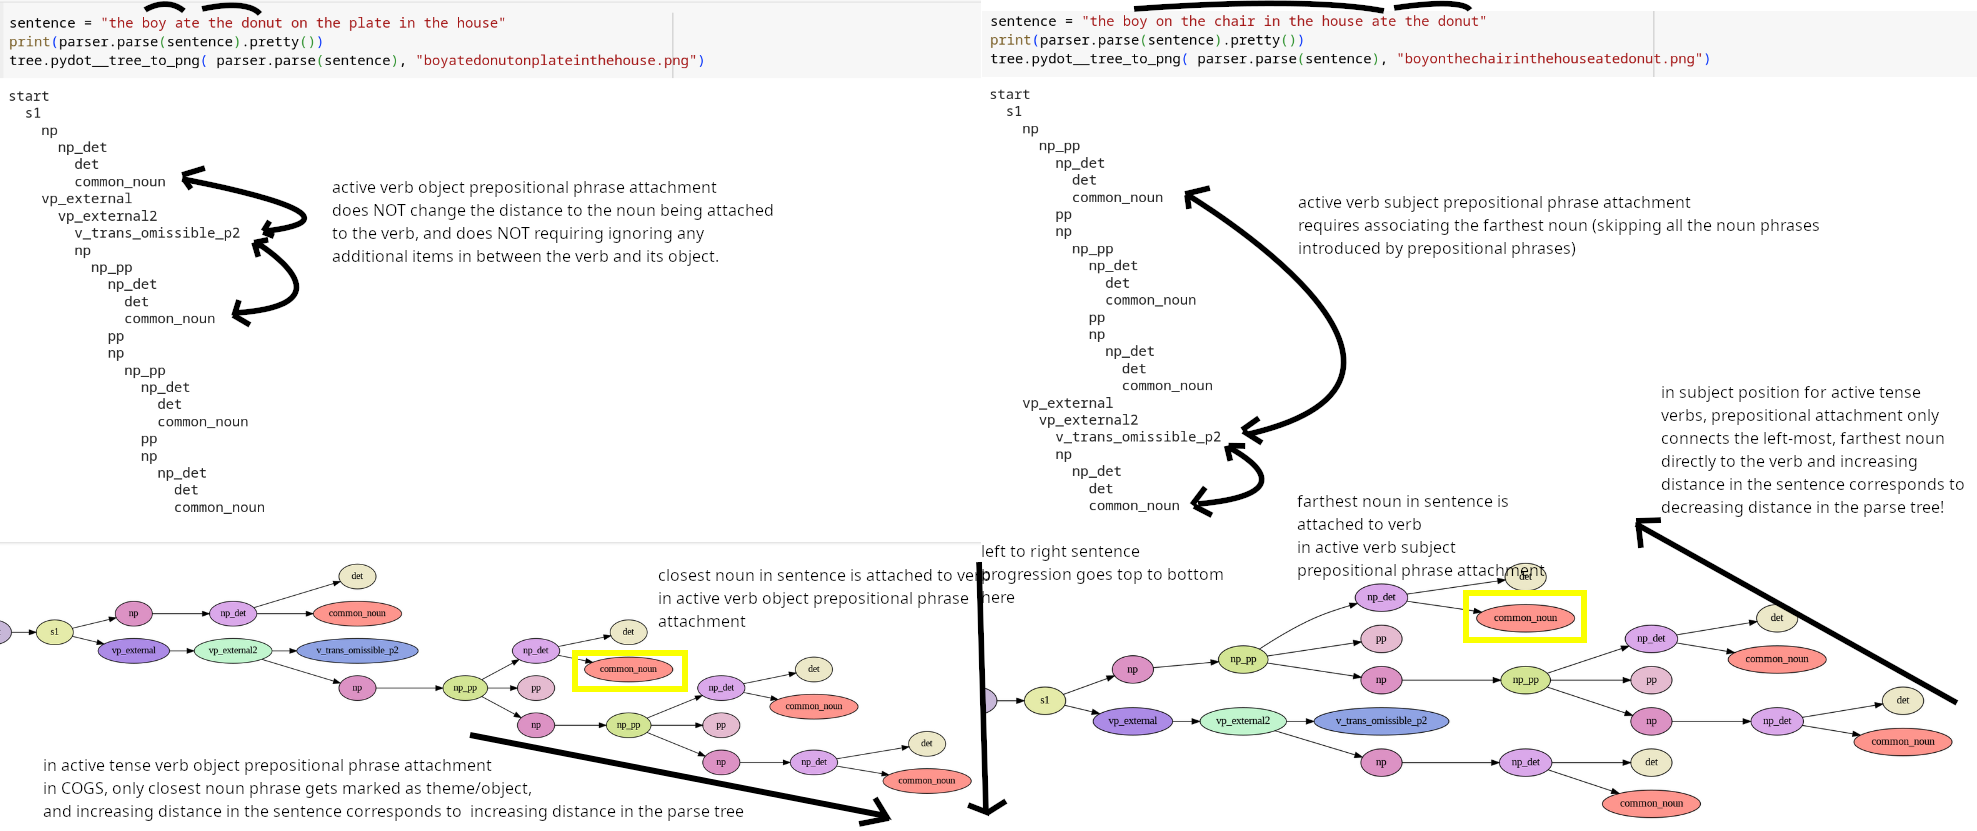

Bit more context from the ReCOGS paper (Wu et al 2023; ReCOGS: How Incidental Details of a Logical Form Overshadow an Evaluation of Semantic Interpretation ; https://arxiv.org/abs/2303.13716 ), they write

```
The hardest COGS split based on published num-
bers seems to be the structural generalization task
that involves interpreting novel combinations of
modified phrases and grammatical role – e.g., in-
terpreting subject noun phrases with PP modifiers
when the train set includes only object noun phrases
with such modifiers (Noah ate the cake on the plate.
→ The cake on the plate burned). To the best of
our knowledge, all prior seq2seq models have com-
pletely failed to get traction here
```

As I write the grammar recognizers by hand in Restricted Access Sequence Processing, it seems a possible reason for Transformer difficulties with generalizing to subject prepositional phrase modification is that the simplest way to recognize the grammar patterns with select and aggregate operators (like attention heads do across sequence in Transformers) will end up learning to match the NPs adjacent to the verb (on either side).

Subject modifying prepositional phrases for active tense verbs in their examples often happen to be modifying the left-argument of the verb and appending additional noun phrases to the right of it, breaking the pattern match, which does not happen when modifying the object of active tense verbs which is appending to the right side of the right-argument of the verb (not changing the closest NP).

A control case to separate the right-to-left argument modification generalization (which is not just left vs right, it is changing the closest NP since we right append "pp np", putting it between e.g. the original agent NP and the verb) of verb prepositional phrase noun modifier effect from object-to-subject prepositional phrase generalization , may be to compare COGS theme np modification for passive verbs with active verbs (compare COGS theme on left vs right of verb modified by prepositional phrase; we could also compare COGS agent NP on left vs right of verb modified by prepositional phrase).


Passive / left verb COGS theme cases where it is predicted to be harder to learn to place prepositional phrases than the active verb cases where the COGS theme noun phrase is immediately to the right of the verb:
```
np was v_trans_not_omissible_pp_p1: The girl was respected.
np was v_trans_not_omissible_pp_p2 by np: The girl was respected by a boy.
np was v_trans_omissible_pp_p1: The girl was painted.
np was v_trans_omissible_pp by np: The girl was painted by a boy.
np was v_unacc_pp_p1: The flower was grown.
np was v_unacc_pp_p2 by np: The flower was grown by a boy.

np v_unacc_p2: The flower grew.
(Note this one is bit ambiguous as the COGS verb theme appears to match the example of a subject position , frequently it is the object and agent is the subject, given in the paper as "grew" can be `burned` here;
but per IBM's grammar for COGS `np v_unacc_p2` (`start -> vp_internal ->  np v_unacc_p2` has a `theme`
and not an `agent`, usually the subject is the agent and theme is object is why I included it in this list.
 In any case we predict it to be difficult for the same reason
and it is consistent with being mentioned in the paper as a failing case,
we just also expect prepositional phrase modifiers on the theme (not agent) of the verb for rest of this group to be hard too.)

np was v_dat_pp_p2 to np by np: The car was sold to the customer by Ella.
np was v_dat_pp_p1 to np: The car was sold to the customer.
```
In these cases the COGS verb theme noun phrase is expected to be harder to learn to modify with prepositional phrases - if we train on the cases where the COGS verb theme noun phrase is on the right of the verb and test on these I expect we would see the same difficulty as they report for training on objects and testing on subjects, because I think the mechanism is the insertion of the interfering distractor "pp np" between the  original theme np and the verb when the theme np is on the left side.

Different case, COGS theme np in the middle of the pattern instead of the left, but I would still predict would have more difficulty with prepositional phrase attachment than right object cases:
```
np v_dat_p1 np pp_iobj
np was v_dat_pp_p4 np by np
```
Will consider to train Transformers from scratch per https://github.com/frankaging/recogs instructions to test those hypotheses.

In any case, since we are implementing a rule-based solution, we can make sure we have symmetry in how the prepositional phrases are handled and avoid that error without specifically targeting it:

In [18]:
process_example("The cake on the plate burned", False)

 	 Example: autoregressive_output(['the', 'cake', 'on', 'the', 'plate', 'burned']) = [|]*6 (strings)

 	 Example: autoregressive_output(['the', 'cake', 'on', 'the', 'plate', 'burned', '|']) = [*]*7 (strings)

 	 Example: autoregressive_output(['the', 'cake', 'on', 'the', 'plate', 'burned', '|', '*']) = [cake]*8 (strings)

 	 Example: autoregressive_output(['the', 'cake', 'on', 'the', 'plate', 'burned', '|', '*', 'cake']) = [(]*9 (strings)

 	 Example: autoregressive_output(['the', 'cake', 'on', 'the', 'plate', 'burned', '|', '*', 'cake', '(']) = [1]*10 (ints)

 	 Example: autoregressive_output(['the', 'cake', 'on', 'the', 'plate', 'burned', '|', '*', 'cake', '(', '1']) = [)]*11 (strings)

 	 Example: autoregressive_output(['the', 'cake', 'on', 'the', 'plate', 'burned', '|', '*', 'cake', '(', '1', ')']) = [;]*12 (strings)

 	 Example: autoregressive_output(['the', 'cake', 'on', 'the', 'plate', 'burned', '|', '*', 'cake', '(', '1', ')', ';']) = [*]*13 (strings)

 	 Example: autoregressiv

' * cake ( 1 ) ; * plate ( 4 ) ; burn ( 5 ) AND theme ( 5 , 1 ) AND nmod . on ( 1 , 4 ) '

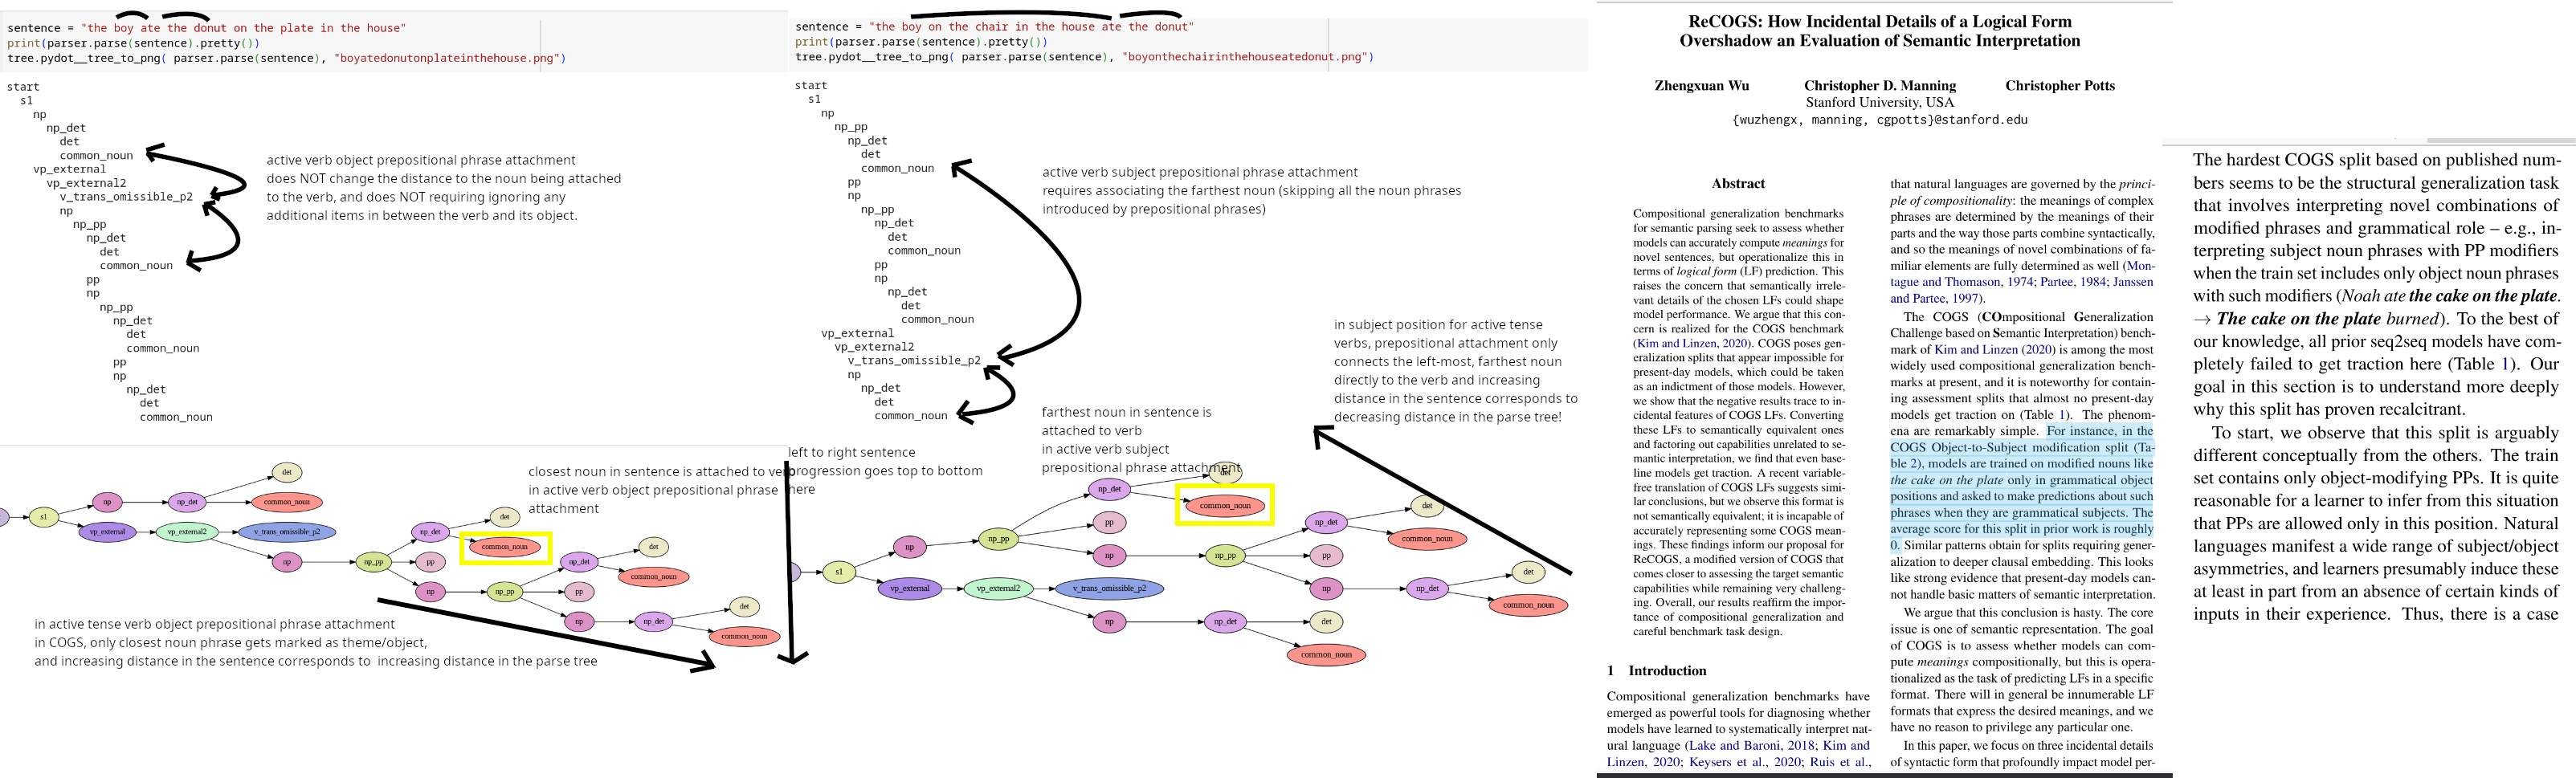

# Exact match (train, knowing for example that all complement phrase grammar is not supported at all)

In [19]:
import pandas as pd

In [20]:
!head -n 5 train.tsv

A rose was helped by a dog .	rose ( 1 ) ; dog ( 6 ) ; help ( 3 ) AND theme ( 3 , 1 ) AND agent ( 3 , 6 )	in_distribution
The sailor dusted a boy .	* sailor ( 1 ) ; boy ( 4 ) ; dust ( 2 ) AND agent ( 2 , 1 ) AND theme ( 2 , 4 )	in_distribution
Emma rolled a teacher .	Emma ( 0 ) ; teacher ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 )	in_distribution
Evelyn rolled the girl .	Evelyn ( 0 ) ; * girl ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 )	in_distribution
A cake was forwarded to Levi by Charlotte .	cake ( 1 ) ; Levi ( 5 ) ; Charlotte ( 7 ) ; forward ( 3 ) AND theme ( 3 , 1 ) AND recipient ( 3 , 5 ) AND agent ( 3 , 7 )	in_distribution


In [21]:
!echo "COGS Sentence	ReCOGS Logical Form	Distribution" > train_in_distribution.tsv
!cat train.tsv | grep 'in_distribution' | grep -v 'sprinkle' | grep -v 'that' >> train_in_distribution.tsv

(note we omit "that" since we have not supported cp_taking yet)

In [22]:
!head -n 5 train_in_distribution.tsv

COGS Sentence	ReCOGS Logical Form	Distribution
A rose was helped by a dog .	rose ( 1 ) ; dog ( 6 ) ; help ( 3 ) AND theme ( 3 , 1 ) AND agent ( 3 , 6 )	in_distribution
The sailor dusted a boy .	* sailor ( 1 ) ; boy ( 4 ) ; dust ( 2 ) AND agent ( 2 , 1 ) AND theme ( 2 , 4 )	in_distribution
Emma rolled a teacher .	Emma ( 0 ) ; teacher ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 )	in_distribution
Evelyn rolled the girl .	Evelyn ( 0 ) ; * girl ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 )	in_distribution


In [23]:
data = pd.read_csv("train_in_distribution.tsv", delimiter="	")

In [24]:
data

,COGS Sentence,ReCOGS Logical Form,Distribution
0,A rose was helped by a dog .,rose ( 1 ) ; dog ( 6 ) ; help ( 3 ) AND theme ...,in_distribution
1,The sailor dusted a boy .,* sailor ( 1 ) ; boy ( 4 ) ; dust ( 2 ) AND ag...,in_distribution
2,Emma rolled a teacher .,Emma ( 0 ) ; teacher ( 3 ) ; roll ( 1 ) AND ag...,in_distribution
3,Evelyn rolled the girl .,Evelyn ( 0 ) ; * girl ( 3 ) ; roll ( 1 ) AND a...,in_distribution
4,A cake was forwarded to Levi by Charlotte .,cake ( 1 ) ; Levi ( 5 ) ; Charlotte ( 7 ) ; fo...,in_distribution
...,...,...,...
20360,Emma gave a cookie beside the bed to a boy .,Emma ( 0 ) ; cookie ( 3 ) ; * bed ( 6 ) ; boy ...,in_distribution
20361,The captain burned .,"* captain ( 1 ) ; burn ( 2 ) AND theme ( 2 , 1 )",in_distribution
20362,The donut was appreciated by a guard .,* donut ( 1 ) ; guard ( 6 ) ; appreciate ( 3 )...,in_distribution
20363,The brush was given to Emma by the girl .,* brush ( 1 ) ; Emma ( 5 ) ; * girl ( 8 ) ; gi...,in_distribution


In [25]:
process_example("the girl needed to cook", False) # v_inf_taking_to_v_inf loses on exact match but is not wrong because of ordering (which is not significant here)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook']) = [|]*5 (strings)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook', '|']) = [*]*6 (strings)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook', '|', '*']) = [girl]*7 (strings)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook', '|', '*', 'girl']) = [(]*8 (strings)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook', '|', '*', 'girl', '(']) = [1]*9 (ints)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook', '|', '*', 'girl', '(', '1']) = [)]*10 (strings)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook', '|', '*', 'girl', '(', '1', ')']) = [;]*11 (strings)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook', '|', '*', 'girl', '(', '1', ')', ';']) = [need]*12 (strings)

 	 Example: autoregressive_output(['the', 'girl', 'needed', 'to', 'cook', '|', '*', 'gi

' * girl ( 1 ) ; need ( 2 ) ; cook ( 4 ) AND agent ( 2 , 1 ) AND xcomp ( 2 , 4 ) AND agent ( 4 , 1 ) '

In [26]:
sentences = data["COGS Sentence"][:100]
lfs_true = data["ReCOGS Logical Form"][:100]

In [27]:
sentences = [sentence.replace(" .", "").replace(".", "") for sentence in sentences]

In [28]:
lfs_computed = []
sentences_translated = []
for sentence in sentences:
  lfs_computed.append(process_example(sentence, False))
  sentences_translated.append(sentence)

Streaming output truncated to the last 5000 lines.
 	 Example: autoregressive_output(['the', 'cake', 'was', 'liked', 'by', 'a', 'lawyer', '|', '*', 'cake', '(', '1', ')', ';', 'lawyer', '(', '6', ')', ';', 'like', '(', '3', ')', 'AND', 'theme', '(', '3']) = [,]*27 (strings)

 	 Example: autoregressive_output(['the', 'cake', 'was', 'liked', 'by', 'a', 'lawyer', '|', '*', 'cake', '(', '1', ')', ';', 'lawyer', '(', '6', ')', ';', 'like', '(', '3', ')', 'AND', 'theme', '(', '3', ',']) = [1]*28 (ints)

 	 Example: autoregressive_output(['the', 'cake', 'was', 'liked', 'by', 'a', 'lawyer', '|', '*', 'cake', '(', '1', ')', ';', 'lawyer', '(', '6', ')', ';', 'like', '(', '3', ')', 'AND', 'theme', '(', '3', ',', '1']) = [)]*29 (strings)

 	 Example: autoregressive_output(['the', 'cake', 'was', 'liked', 'by', 'a', 'lawyer', '|', '*', 'cake', '(', '1', ')', ';', 'lawyer', '(', '6', ')', ';', 'like', '(', '3', ')', 'AND', 'theme', '(', '3', ',', '1', ')']) = [AND]*30 (strings)

 	 Example: autoregr

In [29]:
exact_matches = [1.0 if lfs_computed[idx].strip().lower() == lfs_true[idx].strip().lower() else 0.0 for idx in range(len(lfs_computed))]

In [30]:
import numpy as np
np.array(exact_matches).mean()

0.91

In [36]:
exact_matches

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

note that v_inf_taking_to_v_inf is not ordered for exact match yet so that is causing a lot of misses which are not actually misses

# Semantic Exact Match will be higher ( Exact Match not at 100% yet mostly to v_inf_taking_to_v_inf ordering)

In [31]:
!git clone https://github.com/frankaging/ReCOGS.git

Cloning into 'ReCOGS'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 436 (delta 96), reused 92 (delta 73), pack-reused 312 (from 1)
Receiving objects: 100% (436/436), 84.71 MiB | 24.64 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (137/137), done.


In [32]:
%cd ReCOGS
from utils.train_utils import check_equal
from utils.compgen import recogs_exact_match

/content/RASP/ReCOGS


for semantic exact match, must NOT lowercase the "AND" or it breaks its analysis

In [50]:
semantic_exact_matches1 = [1.0 if recogs_exact_match(lfs_computed[idx].strip().lower().replace(" and ", " AND "),lfs_true[idx].strip().lower().replace(" and ", " AND ")) else 0.0 for idx in range(len(lfs_computed))]

In [51]:
np.array(semantic_exact_matches1).mean()

0.95

In [52]:
exact_matches2 = [1.0 if check_equal(lfs_computed[idx].strip().lower().replace(" and ", " AND "),lfs_true[idx].strip().lower().replace(" and ", " AND ")) else 0.0 for idx in range(len(lfs_computed))]
np.array(exact_matches2).mean()

0.91

In [54]:
semantic_exact_matches1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

Once the implementation of the grammar is complete **(what is used here from draft changes is not complete; all complement phrase handling is absent)**, then a sample of original COGS dataset input sentences plus synthetic sentences required to ensure 100% grammar coverage as defined in "The Fuzzing Book"
( Zeller et al 2023, https://www.fuzzingbook.org/html/GrammarCoverageFuzzer.html ) will be tested to ensure it is getting all possible grammar expansions correct (see definition; avoids infinite recursion issues when exploring grammar). I will also set length limits everywhere and again we assume the limited COGS vocab and grammar (will extend to ReCOGS; right now I am working on COGS grammar but outputting ReCOGS LF). Since we are not using a black box neural network but a program about which we can make general systematic performance statements more easily we aim to try to make a strong claim we are completely covering at least some parts of the grammar, not just getting a certain score on some data.
The grammar coverage will be computed over expansions that collapse all vocabulary leaves to a single leaf (for example not requiring that every particular proper noun or common noun be observed in a particular pattern, so long as one has and we can confirm the code treats them as equivalent; e.g. having tested "Liam drew the cat" and proven that "Liam" and "Noah" are treated as interchangeable proper nouns, and that "cat" and "dog" are treated as interchangeable common nouns by the RASP solution -- not something one can assume for neural network solutions in general -- means that confirming our solution produces the correct logical form for "Liam drew the cat" suffices to prove the RASP solution can handle "Noah drew the dog", which saves us a lot of work so long as we make sure to write our RASP solution such that noah/liam and cat/dog are indeed treated identically).

Though it should be unnecessary if the above can be achieved and the grammar is accurate to the data (note I am using COGS input grammar which is not identical to ReCOGS and will upgrade that in a later commit), I will also measure Semantic Exact Match as defined in Wu et al 2023 ( ReCOGS: How Incidental Details of a Logical Form Overshadow an Evaluation of Semantic Interpretation ; https://arxiv.org/abs/2303.13716 ),  and Exact Match as in the COGS paper, so we have performance metrics in the same format as the Transformers assessed.

In [40]:
lfs_computed

[' rose ( 1 ) ; dog ( 6 ) ; help ( 3 ) AND theme ( 3 , 1 ) AND agent ( 3 , 6 ) ',
 ' * sailor ( 1 ) ; boy ( 4 ) ; dust ( 2 ) AND agent ( 2 , 1 ) AND theme ( 2 , 4 ) ',
 ' emma ( 0 ) ; teacher ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 ) ',
 ' evelyn ( 0 ) ; * girl ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 ) ',
 ' cake ( 1 ) ; levi ( 5 ) ; charlotte ( 7 ) ; forward ( 3 ) AND theme ( 3 , 1 ) AND recipient ( 3 , 5 ) AND agent ( 3 , 7 ) ',
 ' * captain ( 1 ) ; eat ( 2 ) AND agent ( 2 , 1 ) ',
 ' * girl ( 1 ) ; need ( 2 ) ; cook ( 4 ) AND agent ( 2 , 1 ) AND xcomp ( 2 , 4 ) AND agent ( 4 , 1 ) ',
 ' cake ( 1 ) ; roll ( 2 ) AND theme ( 2 , 1 ) ',
 ' * cookie ( 1 ) ; emma ( 5 ) ; pass ( 3 ) AND theme ( 3 , 1 ) AND recipient ( 3 , 5 ) ',
 ' emma ( 0 ) ; * ring ( 3 ) ; bed ( 6 ) ; eat ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 ) AND nmod . beside ( 3 , 6 ) ',
 ' amelia ( 0 ) ; emma ( 2 ) ; strawberry ( 4 ) ; give ( 1 ) AND agent ( 1 , 0 ) AND recipient ( 1 , 2 ) AN

In [42]:
lfs_true.values

array(['rose ( 1 ) ; dog ( 6 ) ; help ( 3 ) AND theme ( 3 , 1 ) AND agent ( 3 , 6 )',
       '* sailor ( 1 ) ; boy ( 4 ) ; dust ( 2 ) AND agent ( 2 , 1 ) AND theme ( 2 , 4 )',
       'Emma ( 0 ) ; teacher ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 )',
       'Evelyn ( 0 ) ; * girl ( 3 ) ; roll ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 )',
       'cake ( 1 ) ; Levi ( 5 ) ; Charlotte ( 7 ) ; forward ( 3 ) AND theme ( 3 , 1 ) AND recipient ( 3 , 5 ) AND agent ( 3 , 7 )',
       '* captain ( 1 ) ; eat ( 2 ) AND agent ( 2 , 1 )',
       '* girl ( 1 ) ; need ( 2 ) AND agent ( 2 , 1 ) AND xcomp ( 2 , 4 ) AND cook ( 4 ) AND agent ( 4 , 1 )',
       'cake ( 1 ) ; roll ( 2 ) AND theme ( 2 , 1 )',
       '* cookie ( 1 ) ; Emma ( 5 ) ; pass ( 3 ) AND theme ( 3 , 1 ) AND recipient ( 3 , 5 )',
       'Emma ( 0 ) ; * ring ( 3 ) ; bed ( 6 ) ; eat ( 1 ) AND agent ( 1 , 0 ) AND theme ( 1 , 3 ) AND nmod . beside ( 3 , 6 )',
       'Amelia ( 0 ) ; Emma ( 2 ) ; strawberry ( 4 ) ; give ( 1 )

use this example a first v_inf_taking_to_v_inf in dataset

In [45]:
lfs_computed[6]

' * girl ( 1 ) ; need ( 2 ) ; cook ( 4 ) AND agent ( 2 , 1 ) AND xcomp ( 2 , 4 ) AND agent ( 4 , 1 ) '

In [46]:
lfs_true[6]

'* girl ( 1 ) ; need ( 2 ) AND agent ( 2 , 1 ) AND xcomp ( 2 , 4 ) AND cook ( 4 ) AND agent ( 4 , 1 )'

In [49]:
recogs_exact_match(lfs_computed[6].strip().lower().replace(" and ", " AND "), lfs_true[6].strip().lower().replace(" and ", " AND "))

True